In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torch.utils.data import DataLoader
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torchvision.datasets as datasets
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [3]:
#constants
PATCH_SIZE = 4
NUM_PATCHES = 28 // PATCH_SIZE #the number of patches in each dimension
D_MODEL = 16 #the dimension of the embedding
CLASSES = 10
BATCH_SIZE = 2

Now, load the MNIST training set and testing set.

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

Here is the first entry in the training set.

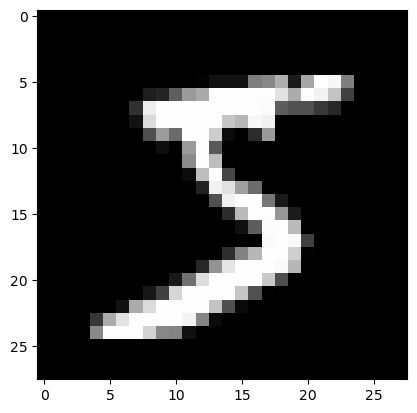

In [5]:
plt.imshow(mnist_trainset[0][0], cmap='gray')

Once the dataset has been loaded, the next step is to break the image into a series of 4x4 pixel images which will the tokens of the model.

In [6]:
def tokenize(img):
    tensorImg = torch.tensor(np.array(img)).to(dtype=torch.float32); 
    tokens = [];
    for i in range(NUM_PATCHES):
        for j in range(NUM_PATCHES):
            tokens.append(tensorImg[4 * i:4 * i + 4,4 * j:4 * j + 4].flatten())
    return torch.stack(tokens)

Class Embeddings takes in the 49x16 vector of the linearized patches and prepends a class token. It then passes them through linear functions and biases to be learned by the network.

In [7]:
class Embeddings(nn.Module):
    def __init__(self, D_MODEL, BATCH_SIZE, PATCH_SIZE, NUM_PATCHES) -> None:
        super().__init__()
        self.D_MODEL = D_MODEL
        self.BATCH_SIZE = BATCH_SIZE
        self.lin = nn.Linear(PATCH_SIZE ** 2, D_MODEL)
        self.pos = nn.Parameter(torch.randn(NUM_PATCHES ** 2 + 1, D_MODEL))
        self.y_p = nn.Parameter(torch.randn(BATCH_SIZE, 1, D_MODEL))

    def forward(self, x_p):
        x_p = self.lin(x_p)
        x_p = torch.cat((self.y_p, x_p), dim = -2)
        return x_p + self.pos
    

Next, LayerNorm is made by passing in tokens so LayerNorm acts on the full embedding layer. It normalizes each patch.

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, tokens, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(tokens))
        self.b_2 = nn.Parameter(torch.zeros(tokens))
        self.eps = eps
    # this normalizes every patch and then normalizes across every patch
    def forward(self, x):
        mean = x.mean(-1, keepdim=True) #this takes the mean across the rows (patches)
        std = x.std(-1, keepdim=True) #this takes the standard deviation across the rows (patches)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [9]:
class Classifier(nn.Module):
    def __init__(self, D_MODEL, HIDDEN_SIZE, CLASSES, transformer, embeddings, pretrainingmlp):
        super().__init__()
        self.pretraining = pretrainingmlp
        self.finetuning = nn.Linear(D_MODEL, CLASSES)
        self.tr = transformer
        self.em = embeddings
    #def forward(self, x):

In [10]:
class PreTrainingMLP(nn.Module):
    def __init__(self, D_MODEL, HIDDEN_SIZE, CLASSES):
        super().__init__()
        self.fc = nn.Linear(D_MODEL, HIDDEN_SIZE)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(HIDDEN_SIZE, CLASSES)
        self.layers = nn.Sequential(self.fc, self.gelu, self.fc2)
    def forward(self, x):
        return self.layers(x)

The transformer acts on the batches of vectors of linearized patches, and the final module is an MLP that acts on the prepended class token with one hidden layer at pretraining time and with a linear layer at fine tuning time.

In [11]:
tokens0 = tokenize(mnist_trainset[0][0])
tokens1 = tokenize(mnist_trainset[1][0])
lin = nn.Linear(16,10)

In [12]:
em = Embeddings(D_MODEL, BATCH_SIZE, PATCH_SIZE, NUM_PATCHES)
#print(em(tokens0)[0])


In [20]:
batch = torch.stack([tokens0,tokens1])
batch.shape
em(batch)
# layernorm = LayerNorm(batch.shape)
# normedBatch = layernorm(batch)
# normedBatch.mean(-1, keepdim=True)

tensor([[[-3.4449e-01, -4.7864e-01, -2.8653e-01,  ..., -2.5952e-02,
          -2.0521e-01,  1.3751e+00],
         [-1.1327e+00,  1.1000e+00, -2.4194e-01,  ..., -1.2333e-01,
           1.5435e+00,  1.5112e+00],
         [-3.7864e-04, -7.6990e-01, -1.0475e+00,  ..., -3.9355e-01,
           1.0118e+00, -6.2245e-01],
         ...,
         [-1.7807e+00, -6.8818e-01,  5.9281e-01,  ...,  3.1664e-01,
           7.4327e-01,  2.6858e+00],
         [ 5.0717e-02, -8.0919e-01, -1.6948e+00,  ...,  1.0464e+00,
           1.2079e+00, -5.7070e-01],
         [ 2.4583e+00, -8.4517e-01, -7.0536e-01,  ..., -1.0270e+00,
           7.6805e-02, -8.2188e-01]],

        [[ 8.2550e-01,  2.3085e-01,  1.0177e-01,  ..., -1.9093e+00,
           8.6269e-01,  1.5456e+00],
         [-1.1327e+00,  1.1000e+00, -2.4194e-01,  ..., -1.2333e-01,
           1.5435e+00,  1.5112e+00],
         [-3.7864e-04, -7.6990e-01, -1.0475e+00,  ..., -3.9355e-01,
           1.0118e+00, -6.2245e-01],
         ...,
         [-1.7807e+00, -6